In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

In [2]:
df1 = pd.read_csv("./TD_HOSPITAL_TRAIN.csv")
print(df1.shape)
df1.head(5)

(7058, 44)


,timeknown,cost,reflex,sex,blood,bloodchem1,bloodchem2,temperature,race,heart,...,diabetes,income,extraprimary,bloodchem6,education,psych5,psych6,information,cancer,death
0,4.0,3008.38867,11.228005,male,20.699219,2.199707,1.299805,35.59375,white,103.0,...,0.0,$11-$25k,COPD/CHF/Cirrhosis,167.5000,20.0,30.0,2.000,0.0,no,1.0
1,467.0,23585.89060,9.714861,M,9.398438,NaN,0.699951,39.00000,white,50.0,...,0.0,>$50k,Cancer,480.0000,16.0,11.5,1.000,10.0,metastatic,1.0
2,533.0,4046.45898,11.353296,Male,19.296875,NaN,1.599854,38.19531,white,50.0,...,1.0,under $11k,ARF/MOSF,177.1250,5.0,18.0,0.000,5.0,yes,0.0
3,68.0,NaN,9.269058,female,7.500000,2.500000,0.599976,37.59375,white,80.0,...,0.0,$11-$25k,COPD/CHF/Cirrhosis,NaN,12.0,7.0,1.839,12.0,no,1.0
4,1605.0,6457.70703,8.655387,female,15.099609,4.399414,0.699951,35.69531,white,114.0,...,0.0,under $11k,COPD/CHF/Cirrhosis,233.3125,2.0,7.0,6.000,12.0,no,0.0


In [3]:
# y = df1['death']
# print(y.shape)
# print(df1.shape)

In [4]:
df1[:5]

,timeknown,cost,reflex,sex,blood,bloodchem1,bloodchem2,temperature,race,heart,...,diabetes,income,extraprimary,bloodchem6,education,psych5,psych6,information,cancer,death
0,4.0,3008.38867,11.228005,male,20.699219,2.199707,1.299805,35.59375,white,103.0,...,0.0,$11-$25k,COPD/CHF/Cirrhosis,167.5000,20.0,30.0,2.000,0.0,no,1.0
1,467.0,23585.89060,9.714861,M,9.398438,NaN,0.699951,39.00000,white,50.0,...,0.0,>$50k,Cancer,480.0000,16.0,11.5,1.000,10.0,metastatic,1.0
2,533.0,4046.45898,11.353296,Male,19.296875,NaN,1.599854,38.19531,white,50.0,...,1.0,under $11k,ARF/MOSF,177.1250,5.0,18.0,0.000,5.0,yes,0.0
3,68.0,NaN,9.269058,female,7.500000,2.500000,0.599976,37.59375,white,80.0,...,0.0,$11-$25k,COPD/CHF/Cirrhosis,NaN,12.0,7.0,1.839,12.0,no,1.0
4,1605.0,6457.70703,8.655387,female,15.099609,4.399414,0.699951,35.69531,white,114.0,...,0.0,under $11k,COPD/CHF/Cirrhosis,233.3125,2.0,7.0,6.000,12.0,no,0.0


In [5]:
class Dataset(object):
    def __init__(self, data: pd.DataFrame) -> None:
        # drop columns
        self.data = data.copy()

        # drop columns
        self.data = self.data.drop('pdeath',axis=1)
        self.data = self.data.drop('psych4',axis=1)
        self.data = self.data.drop('glucose',axis=1)
        self.data = self.data.drop('bloodchem4', axis=1)
        self.data = self.data.drop('urine',axis =1)
        self.data = self.data.drop('income',axis =1)

        # clean data
        self.data = self.data.apply(self.clean, axis=1)

        # replace missing data
        self.clean_fill_mean('psych2')
        self.clean_fill_mean('bloodchem3')
        self.replace_missing_with_knn('totalcost', n_neighbors=10)
        self.replace_missing_with_knn('confidence', n_neighbors=10)
        self.replace_missing_with_knn('bloodchem1', n_neighbors=10)
        self.replace_missing_with_knn('bloodchem2', n_neighbors=10)
        self.replace_missing_with_knn('blood', n_neighbors=10)
        self.replace_missing_with_knn('cost', n_neighbors=10)
        self.replace_missing_with_knn('sleep', n_neighbors=10)
        self.replace_missing_with_knn('bloodchem5', n_neighbors=10)
        self.replace_missing_with_mode('disability')
        self.replace_missing_with_knn('administratorcost')
        self.replace_missing_with_knn('diabetes')
        self.replace_missing_with_knn('bloodchem6')
        self.replace_missing_with_knn('education')
        self.replace_missing_with_knn('psych5')
        self.replace_missing_with_knn('psych6')
        self.replace_missing_with_knn('information')


        # one hot encode the data
        self.one_hot_encode_feature('cancer')
        self.one_hot_encode_feature('extraprimary')
        self.one_hot_encode_feature('dnr')
        self.one_hot_encode_feature('primary')
        self.one_hot_encode_feature('disability')


    
    def clean(self, row):
        row.sex = self.cleanSex(row.sex)
        row.race = self.cleanRace(row.race)
        row.cost = self.cleanCost(row.cost)
        
        return row
    
    # preproc for cost
    def cleanCost(self, val: float):
        if pd.isna(val) or val < 0:
            return np.nan
        
        return val


    # preproc logic for cleaning sex
    def cleanSex(self, val):
        val = val.lower()
        # 1: male
        if val in ['male', 'm', '1']:
            return 1
        # 0: female
        return 0

    # preproc logic for race
    def cleanRace(self, val):
        # unique values: ['white', 'black', 'hispanic', 'other', nan, 'asian']
        WHITE = 0
        BLACK = 1
        HISPANIC = 2
        OTHER = 3
        ASIAN = 4

        if(pd.isna(val)):
            return OTHER
        
        val = val.lower()

        if val == 'white':
            return WHITE
        elif val == 'black':
            return BLACK
        elif val == 'hispanic':
            return HISPANIC
        elif val == 'other':
            return OTHER
        elif val == 'asian':
            return ASIAN


        print('not possible')
        return -1
    

    def one_hot_encode_feature(self, feature_name):
        """
        One-hot encodes a specified feature from a DataFrame.

        Parameters:
        - dataframe: The input DataFrame.
        - feature_name: The name of the feature to be one-hot encoded.

        Returns:
        - one_hot_df: A DataFrame containing the one-hot encoded feature.
        """

        # Select the specified feature from the DataFrame
        feature_to_encode = self.data[feature_name]

        # Reshape the feature to have a 2D shape, required by OneHotEncoder
        feature_to_encode = feature_to_encode.values.reshape(-1, 1)

        # Create an instance of the OneHotEncoder
        encoder = OneHotEncoder(sparse=False)  # You can set sparse=True if you want a sparse matrix

        # Fit the encoder to the feature data
        encoder.fit(feature_to_encode)

        # Transform the feature data to one-hot encoded format
        one_hot_encoded = encoder.transform(feature_to_encode)

        # Convert the one-hot encoded data to a DataFrame for better visualization
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out([feature_name]))
        
        
        new_dataframe = self.data.drop(columns=[feature_name])  # Remove the target column
        new_dataframe[one_hot_df.columns] = one_hot_df  # Add the source columns to the target DataFrame
        
        self.data = new_dataframe

    # for glucose, psych2, 
    def clean_fill_mean(self, feature):
        mean_value = self.data[feature].mean()
        self.data[feature].fillna(mean_value, inplace=True)


    # replacing the outliers after replacing missing values
    def replace_outliers_with_mean(self, column_name, threshold=1.5):
        # Calculate lower and upper bounds for outliers
        Q1 = self.data[column_name].quantile(0.25)
        Q3 = self.data[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Identify outliers in the specified column
        outliers = self.data[(self.data[column_name] < lower_bound) | (self.data[column_name] > upper_bound)]

        # Replace outliers with the mean of the column
        non_outliers_mean = self.data[([column_name] >= lower_bound) & (self.data[column_name] <= upper_bound)][column_name].mean()
        self.data.loc[outliers.index, column_name] = non_outliers_mean


    #replacing missing values with knn imputer
    # for totalcost
    def replace_missing_with_knn(self, column_name, n_neighbors=5):
        # Create a copy of the DataFrame to avoid modifying the original data
        df_imputed = self.data.copy()    
        # Extract the column with missing values for imputation
        column_to_impute = df_imputed[[column_name]]   
        # Initialize KNNImputer with the desired number of neighbors
        imputer = KNNImputer(n_neighbors=n_neighbors)   
        # Perform KNN imputation on the specified column
        column_imputed = imputer.fit_transform(column_to_impute)   
        # Replace the missing values in the original DataFrame with imputed values
        df_imputed[column_name] = column_imputed
        
        self.data = df_imputed

    
    def replace_missing_with_mode(self, categorical_feature):
        """
        Fill missing values in a categorical feature with the most frequent category.

        Parameters:
        - df: DataFrame containing the data.
        - categorical_feature: Name of the categorical feature/column with missing values.

        Returns:
        - Updated DataFrame with missing values filled in the specified feature.
        """
        # Find the most frequent category in the specified feature
        most_frequent_category = self.data[categorical_feature].mode()[0]
        
        # Fill missing values in the specified feature with the most frequent category
        self.data[categorical_feature].fillna(most_frequent_category, inplace=True)
        
    # Example Usage:
    # Assuming 'df' is your DataFrame and 'categorical_column' is the name of the categorical feature with missing values
    # df = fill_missing_categorical(df, 'categorical_column')


In [6]:
cleaned_data = Dataset(df1).data
cleaned_data[:5]

/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/Geetesh/anaconda3/envs/work/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning:

,timeknown,cost,reflex,sex,blood,bloodchem1,bloodchem2,temperature,race,heart,...,primary_Cirrhosis,primary_Colon Cancer,primary_Coma,primary_Lung Cancer,primary_MOSF w/Malig,disability_<2 mo. follow-up,disability_Coma or Intub,disability_SIP>=30,disability_adl>=4 (>=5 if sur),disability_no(M2 and SIP pres)
0,4.0,3008.388670,11.228005,1,20.699219,2.199707,1.299805,35.59375,0,103.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,467.0,23585.890600,9.714861,1,9.398438,2.946952,0.699951,39.00000,0,50.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,533.0,4046.458980,11.353296,1,19.296875,2.946952,1.599854,38.19531,0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,68.0,28703.389688,9.269058,0,7.500000,2.500000,0.599976,37.59375,0,80.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1605.0,6457.707030,8.655387,0,15.099609,4.399414,0.699951,35.69531,0,114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
df1[:5]

,timeknown,cost,reflex,sex,blood,bloodchem1,bloodchem2,temperature,race,heart,...,diabetes,income,extraprimary,bloodchem6,education,psych5,psych6,information,cancer,death
0,4.0,3008.38867,11.228005,male,20.699219,2.199707,1.299805,35.59375,white,103.0,...,0.0,$11-$25k,COPD/CHF/Cirrhosis,167.5000,20.0,30.0,2.000,0.0,no,1.0
1,467.0,23585.89060,9.714861,M,9.398438,NaN,0.699951,39.00000,white,50.0,...,0.0,>$50k,Cancer,480.0000,16.0,11.5,1.000,10.0,metastatic,1.0
2,533.0,4046.45898,11.353296,Male,19.296875,NaN,1.599854,38.19531,white,50.0,...,1.0,under $11k,ARF/MOSF,177.1250,5.0,18.0,0.000,5.0,yes,0.0
3,68.0,NaN,9.269058,female,7.500000,2.500000,0.599976,37.59375,white,80.0,...,0.0,$11-$25k,COPD/CHF/Cirrhosis,NaN,12.0,7.0,1.839,12.0,no,1.0
4,1605.0,6457.70703,8.655387,female,15.099609,4.399414,0.699951,35.69531,white,114.0,...,0.0,under $11k,COPD/CHF/Cirrhosis,233.3125,2.0,7.0,6.000,12.0,no,0.0


In [8]:
# !pip install tensorflow keras

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

In [19]:
def split_feature_label(df):
    y = df['death']
    X = df.drop(columns=['death'])
    return y, X
    # print(X)
    # print(y)

    # death_0 = y.tolist().count(0)
    # death_1 = y.tolist().count(1)
    # percent_death_0 = 100 * death_0 / (death_0 + death_1)
    # percent_death_1 = 100 * death_1 / (death_0 + death_1)
    # print(f'Survived: {death_0}, or {percent_death_0:.2f}%')
    # print(f'Died: {death_1}, or {percent_death_1:.2f}%')

def standardize(X):
    scaler = StandardScaler()
    X_numeric = scaler.fit_transform(X.select_dtypes(include=['float64']))
    X[X.select_dtypes(include=['float64']).columns] = X_numeric
    return X

def train_model(X, y):
    # Split data into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.3, random_state=42)

    # Define the neural network model
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),  # Input layer
        layers.Dense(128, activation='relu'),     # Hidden layer with 128 neurons and ReLU activation
        layers.Dense(64, activation='relu'),      # Another hidden layer with 64 neurons and ReLU activation
        layers.Dense(1, activation='sigmoid')     # Output layer with sigmoid activation for binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    
    model.save('example.h5')

    
    
    print(f'Test accuracy: {test_accuracy}')

    # Optionally, you can plot training history to visualize model performance
    import matplotlib.pyplot as plt

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

Epoch 1/50
177/177 [==============================] - 0s 821us/step - loss: 0.3788 - accuracy: 0.8181 - val_loss: 0.3669 - val_accuracy: 0.8188
Epoch 2/50
177/177 [==============================] - 0s 571us/step - loss: 0.3051 - accuracy: 0.8643 - val_loss: 0.3493 - val_accuracy: 0.8340
Epoch 3/50
177/177 [==============================] - 0s 567us/step - loss: 0.2779 - accuracy: 0.8742 - val_loss: 0.3310 - val_accuracy: 0.8401
Epoch 4/50
177/177 [==============================] - 0s 553us/step - loss: 0.2543 - accuracy: 0.8870 - val_loss: 0.3451 - val_accuracy: 0.8310
Epoch 5/50
177/177 [==============================] - 0s 568us/step - loss: 0.2347 - accuracy: 0.8957 - val_loss: 0.3236 - val_accuracy: 0.8532
Epoch 6/50
177/177 [==============================] - 0s 559us/step - loss: 0.2227 - accuracy: 0.9051 - val_loss: 0.3242 - val_accuracy: 0.8451
Epoch 7/50
177/177 [==============================] - 0s 563us/step - loss: 0.2049 - accuracy: 0.9125 - val_loss: 0.3143 - val_accuracy:

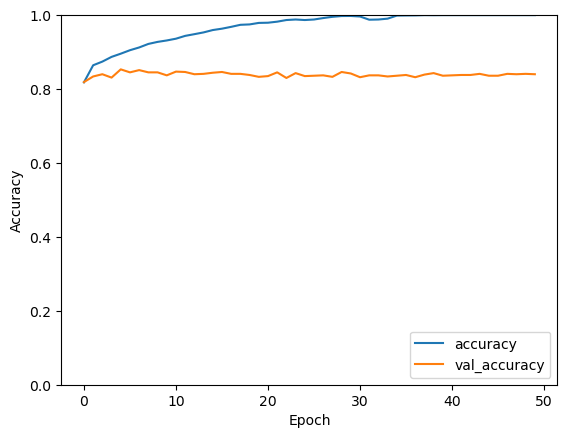

In [20]:
y, X = split_feature_label(cleaned_data)
X = standardize(X)
train_model(X, y)

<h1>Lab

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.3, random_state=42)

model2 = load_model('example.h5')
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
train_loss, train_accuracy = model2.evaluate(X_train, y_train)

print(f'Train accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')

177/177 [==============================] - 0s 286us/step - loss: 0.0028 - accuracy: 1.0000
Train accuracy: 1.0
Test accuracy: 0.8584905862808228


In [12]:
# k9[]

In [13]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [14]:
# model = keras.Sequential([
#         layers.Input(shape=(X_train.shape[1],)),  # Input layer
#         layers.Dense(128, activation='relu'),     # Hidden layer with 128 neurons and ReLU activation
#         layers.Dense(64, activation='relu'),      # Another hidden layer with 64 neurons and ReLU activation
#         layers.Dense(1, activation='sigmoid')     # Output layer with sigmoid activation for binary classification
#     ])

In [15]:
# y, X = split_feature_label(cleaned_data)
# X = standardize(X)
# train_model(X, y)

In [16]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.layers import Dropout
# from sklearn.linear_model import LogisticRegression
# from tensorflow.keras import regularizers
# from sklearn.metrics import log_loss
# from sklearn.metrics import accuracy_score



# def data_preprocessing(df):
    
#     col_to_keep = ['death', 'age', 'blood', 'reflex', 'bloodchem1', 'bloodchem2', 'psych1', 'glucose']
#     df = df[col_to_keep]

#     df.replace('', 0, inplace=True)
#     df.fillna(0, inplace=True)
#     return df
    
# def split_feature_label(df):
#     y = df['death']
#     X = df.drop(columns=['death'])
#     return y, X
#     # print(X)
#     # print(y)

#     # death_0 = y.tolist().count(0)
#     # death_1 = y.tolist().count(1)
#     # percent_death_0 = 100 * death_0 / (death_0 + death_1)
#     # percent_death_1 = 100 * death_1 / (death_0 + death_1)
#     # print(f'Survived: {death_0}, or {percent_death_0:.2f}%')
#     # print(f'Died: {death_1}, or {percent_death_1:.2f}%')

# def standardize(X):
#     scaler = StandardScaler()
#     X_numeric = scaler.fit_transform(X.select_dtypes(include=['float64']))
#     X[X.select_dtypes(include=['float64']).columns] = X_numeric
#     return X

# def train_model(X, y):
#     # Split data into training and validation
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#     X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#     # Define the neural network model
#     model = keras.Sequential([
#         layers.Input(shape=(X_train.shape[1],)),  # Input layer
#         layers.Dense(512, activation='relu',kernel_regularizer=regularizers.L1(0.01)), 
#         layers.Dropout(0.5),
#         layers.Dense(256, activation='relu',kernel_regularizer=regularizers.L1(0.01)),
#         layers.Dropout(0.5),
#         layers.Dense(128, activation='relu',kernel_regularizer=regularizers.L1(0.01)),  # Hidden layer with 128 neurons and ReLU activation
#         layers.Dropout(0.5),
#         layers.Dense(64, activation='relu' ,kernel_regularizer=regularizers.L1(0.01)),      # Another hidden layer with 64 neurons and ReLU activation
#         layers.Dense(1, activation='sigmoid')     # Output layer with sigmoid activation for binary classification
#     ])

#     # Compile the model
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     # Train the model
#     history = Logistic_reg = LogisticRegression(random_state=42,max_iter=10000).fit(X_train, y_train)

#     # Evaluate the model on the test set
#     y_pred_proba = Logistic_reg.predict_proba(X_test)

#     # Calculate the log loss
#     test_loss = log_loss(y_test, y_pred_proba)
#     y_pred = Logistic_reg.predict(X_test)

#     # Calculate the accuracy
#     test_accuracy = accuracy_score(y_test, y_pred)
    
#     model.save('example.h5')
    
#     print(f'Test accuracy: {test_accuracy}')

#     # Optionally, you can plot training history to visualize model performance
#     import matplotlib.pyplot as plt

# #     plt.plot(history.history['accuracy'], label='accuracy')
# #     plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# #     plt.xlabel('Epoch')
# #     plt.ylabel('Accuracy')
# #     plt.ylim([0, 1])
# #     plt.legend(loc='lower right')
# #     plt.show()



# if __name__ == "__main__":
#     data_path = "C:/Users/Manoj Reddy Gurram/Desktop/TDHospital/TDHospital/TD_HOSPITAL_TRAIN.csv"
#     df = pd.read_csv(data_path)
#     cleaned_data = data_preprocessing(df)
#     y, X = split_feature_label(cleaned_data)
#     X = standardize(X)
#     train_model(X, y)
    

In [17]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.layers import Dropout
# from sklearn.linear_model import LogisticRegression
# from tensorflow.keras import regularizers
# from sklearn.metrics import log_loss
# from sklearn.metrics import accuracy_score
# from sklearn.ensemble import RandomForestClassifier

# def data_preprocessing(df):
    
#     col_to_keep = ['death', 'age', 'blood', 'reflex', 'bloodchem1', 'bloodchem2', 'psych1', 'glucose']
#     df = df[col_to_keep]

#     df.replace('', 0, inplace=True)
#     df.fillna(0, inplace=True)
#     return df
    
# def split_feature_label(df):
#     y = df['death']
#     X = df.drop(columns=['death'])
#     return y, X
#     # print(X)
#     # print(y)

#     # death_0 = y.tolist().count(0)
#     # death_1 = y.tolist().count(1)
#     # percent_death_0 = 100 * death_0 / (death_0 + death_1)
#     # percent_death_1 = 100 * death_1 / (death_0 + death_1)
#     # print(f'Survived: {death_0}, or {percent_death_0:.2f}%')
#     # print(f'Died: {death_1}, or {percent_death_1:.2f}%')

# def standardize(X):
#     scaler = StandardScaler()
#     X_numeric = scaler.fit_transform(X.select_dtypes(include=['float64']))
#     X[X.select_dtypes(include=['float64']).columns] = X_numeric
#     return X

# def train_model(X, y):
#     # Split data into training and validation
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#     X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#     # Define the neural network model
#     rf_classifier = RandomForestClassifier()
#     history = rf_classifier.fit(X_train, y_train)

#     # Evaluate the model on the test set
#     y_pred_proba = rf_classifier.predict_proba(X_test)

#     # Calculate the log loss
#     test_loss = log_loss(y_test, y_pred_proba)
#     y_pred = rf_classifier.predict(X_test)

#     # Calculate the accuracy
#     test_accuracy = accuracy_score(y_test, y_pred)
    
    
#     print(f'Test accuracy: {test_accuracy}')

#     # Optionally, you can plot training history to visualize model performance
#     import matplotlib.pyplot as plt

# #     plt.plot(history.history['accuracy'], label='accuracy')
# #     plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# #     plt.xlabel('Epoch')
# #     plt.ylabel('Accuracy')
# #     plt.ylim([0, 1])
# #     plt.legend(loc='lower right')
# #     plt.show()



# if __name__ == "__main__":
#     data_path = "C:/Users/Manoj Reddy Gurram/Desktop/TDHospital/TDHospital/TD_HOSPITAL_TRAIN.csv"
#     df = pd.read_csv(data_path)
#     cleaned_data = data_preprocessing(df)
#     y, X = split_feature_label(cleaned_data)
#     X = standardize(X)
#     train_model(X, y)
    